In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import re
import cv2

import sys
sys.path.append("..")
sys.path.append("../src")
from src import RUGDH5Dataset, DeepEvidentialSegModelConfig, FPNFeatureExtractorConfig, PatchDecoderConfig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from src.utils import image_reverse_transforms, label2name
from src import TRAIN_STAGE

In [3]:
# 设置设备和混合精度训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler(device=device)

# 设置超参数
epochs = 50
lr = 1e-5
batch_size = 16

# 加载数据集
dataset = RUGDH5Dataset('../data/rugd_train.h5')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 模型设置部分
## 初始化模型
feature_extractor_config = FPNFeatureExtractorConfig()
patch_decoder_config = PatchDecoderConfig(
    num_samples=1024,
)
model_config = DeepEvidentialSegModelConfig(
    feature_extractor_config=feature_extractor_config,
    patch_decoder_config=patch_decoder_config,
    num_classes=20,
    train_stage=TRAIN_STAGE.RECONSTRUCTION,
)
model = model_config.make_model(device=device)

In [4]:
ckpt = torch.load(
    '../checkpoints/classi_w_recon/deep_evidential_seg_model_final.pth', 
    map_location=device
)

# filter_keys = re.compile(r'path_decoder.*') # path 是写错了，应该是 patch 但是不能改。
# ckpt = {k: v for k, v in ckpt.items() if not filter_keys.match(k)}

model.load_state_dict(ckpt)

RuntimeError: Error(s) in loading state_dict for DeepEvidentialSegModel:
	Missing key(s) in state_dict: "log_density_scale", "feature_norm.weight", "feature_norm.bias", "feature_norm.running_mean", "feature_norm.running_var". 

In [4]:
def visualize_with_legend(ax, mask, title, label2name):
    # 1. Get unique classes present in this specific mask
    unique_labels = np.unique(mask)
    
    # 2. Generate a colormap with enough colors for the max label index (25)
    # using 'tab20' or 'jet' usually provides distinct colors
    base_cmap = plt.get_cmap('tab20b', 25) 
    
    # 3. Plot the image
    im = ax.imshow(mask, cmap=base_cmap, vmin=0, vmax=24)
    ax.set_title(title)
    
    # 4. Create the legend handles manually
    legend_patches = []
    for label_idx in unique_labels:
        if label_idx in label2name:
            # Get the color corresponding to this label from the colormap
            color = base_cmap(label_idx / 24.0) 
            patch = mpatches.Patch(color=color, label=f"{label_idx}: {label2name[label_idx]}")
            legend_patches.append(patch)
    
    # 5. Add legend to the side of the plot
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


torch.Size([3, 544, 672])
3 15


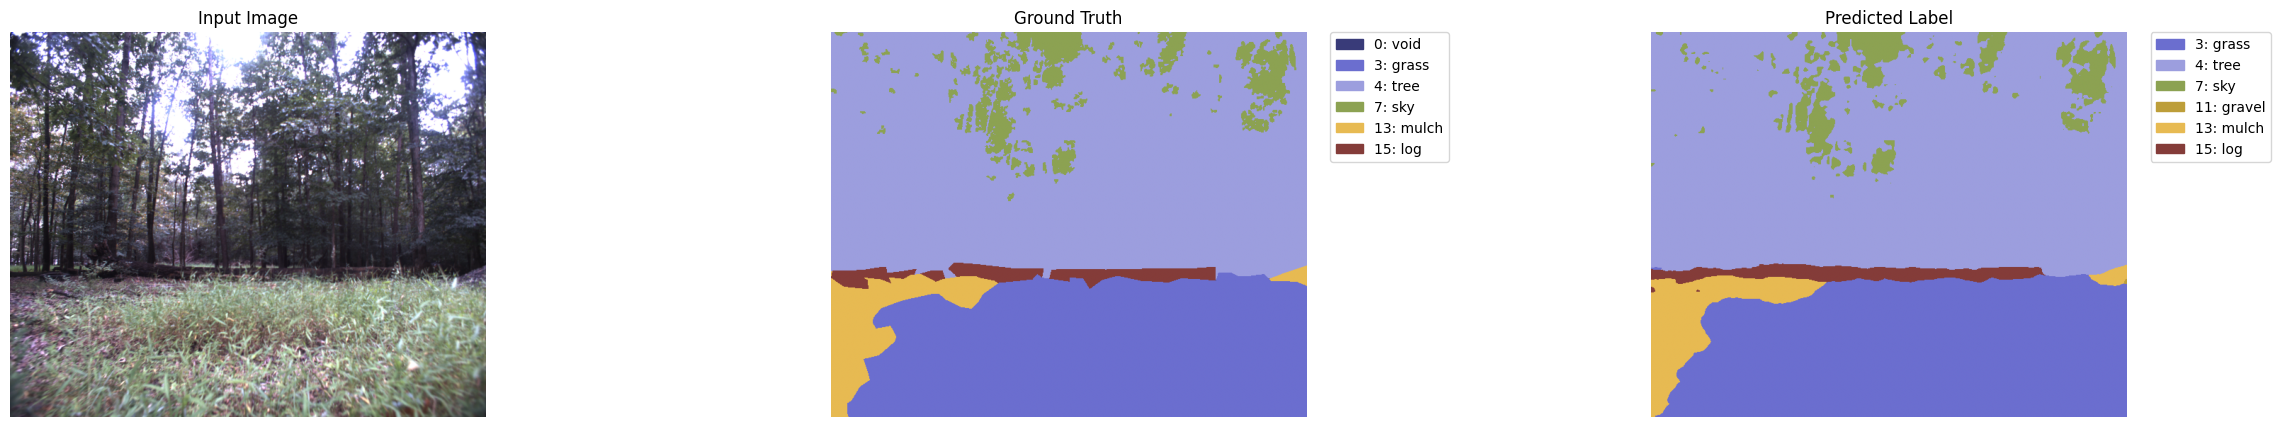

In [14]:
idx = torch.randint(0, len(dataset), (1,)).item()
image, label = dataset[idx]
print(image.shape)
raw_image = image_reverse_transforms(image)
raw_image = raw_image.permute(1, 2, 0).cpu().numpy()

with torch.no_grad():
    model.eval()
    _, logits, _ = model.classify(image.unsqueeze(0).to(device))
    predicted_label = torch.argmax(logits, dim=1).cpu().squeeze().numpy()

print(predicted_label.min(), predicted_label.max())

    

fig, ax = plt.subplots(1, 3, figsize=(30, 5)) # Increased width slightly for legends

# Plot 1: Input Image
ax[0].set_title('Input Image')
ax[0].imshow(raw_image)
ax[0].axis('off')

# Plot 2: Ground Truth with Legend
visualize_with_legend(ax[1], label, 'Ground Truth', label2name)
ax[1].axis('off')

# Plot 3: Predicted Label with Legend
visualize_with_legend(ax[2], predicted_label, 'Predicted Label', label2name)
ax[2].axis('off')

plt.show()

In [15]:
features = model.feature_extractor.forward(image.unsqueeze(0).to(device))
print(features.shape)

torch.Size([1, 128, 136, 168])


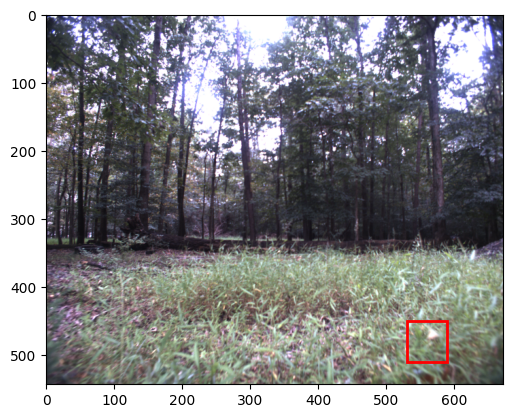

In [16]:
feature_x, feature_y = 120, 140
mid = features[..., feature_x, feature_y]
image_x, image_y = feature_x * 4, feature_y * 4

x1, y1 = image_x - 30, image_y - 30
x2, y2 = image_x + 30, image_y + 30

raw_image_region = (raw_image * 255).astype(np.uint8).transpose(2, 0, 1)
plt.imshow(raw_image_region.transpose(1, 2, 0))
plt.gca().add_patch(mpatches.Rectangle((y1, x1), y2 - y1, x2 - x1, linewidth=2, edgecolor='r', facecolor='None'))
plt.show()

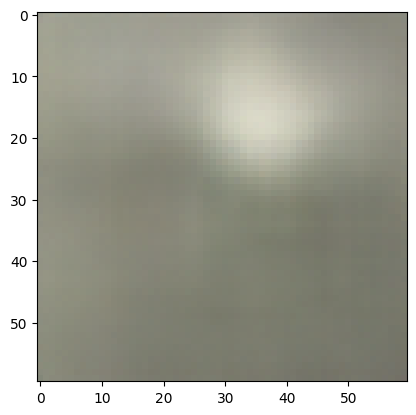

In [17]:
patch = model.patch_decoder.forward(mid)
patch.shape

raw_patch = image_reverse_transforms(patch.squeeze().cpu().detach())
plt.imshow(raw_patch.permute(1, 2, 0))